<h1><b>Implementation and improvement</b>
<b>of original ResNet-18 using CIFAR10 dataset</b></h1>

#Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

In [2]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

def load_model(model, path):
  model.load_state_dict(torch.load(path))

#Helper Functions

In [3]:
def load_cifar_dataset():

  """
  Function to load the CIFAR10 dataset that returns a separate train and test set.
  Images resized to 64x64 and normalised using the datasets mean and std.
  """


  train_data = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(64),                                                                                
                               transforms.ToTensor(),
                               transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))

  test_data = datasets.CIFAR10(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               transforms.Resize(64),                                      
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))
  
  return train_data, test_data


def split_train_val(train_data):
  """
  Split data into train and validation sets
  """
  
  train_set, val_set = torch.utils.data.random_split(train_data, [45000, 5000])
  return train_set, val_set

def get_classes(dataset):
  return dataset.classes

In [4]:
def train(model, train_loader, loss_function, optimizer, epoch):
    """
    Training function for one epoch to be called in model_fit function
    """

    model.train()
    train_loss = 0
    train_correct = 0

    for idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        # compute loss
        output = model(data)
        loss = loss_function(output, target)


        # update using gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #correct = predictions(output, target)

        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()

        train_correct += correct
        train_loss += loss.data.item()

        if (idx + 1)% 50 == 0:

          print('Epoch Progress: {:.0f}% Done\tCurrent Loss: {:.5f}'.format(100. * (idx + 1) / len(train_loader), loss.data.item()))
    
    # Get training epoch loss and accuracy
    train_loss /= len(train_loader.dataset)
    epoch_acc = float(train_correct) / len(train_loader.dataset)
    print('\nAverage training loss: {:.5f}, Training Accuracy: {}/{} ({:.3f}%)'.format(
      train_loss, train_correct, len(train_loader.dataset),100.0 * epoch_acc))
    return train_loss, epoch_acc

def validate(model, val_loader, loss_function):
    """
    Function to evaluate model at certain epoch on the validation set
    """
    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
      for idx, (data, target) in enumerate(val_loader):

          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          val_loss += loss_function(output, target).data.item()

          #correct = predictions(output, target)
          #val_correct+=correct

          pred = output.data.max(1, keepdim=True)[1]
          val_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
      val_loss /= len(val_loader.dataset)
      epoch_acc = float(val_correct) / len(val_loader.dataset)
      print('Average validation loss: {:.5f}, Validation Accuracy: {}/{} ({:.3f}%)\n'.format(
          val_loss, val_correct, len(val_loader.dataset),100.0 * epoch_acc))
    return val_loss, epoch_acc

def test(model, test_loader):
    model.eval()

    images = []
    labels = []
    predict = []

    correct = 0
    with torch.no_grad():
    
        for idx, (data, target) in enumerate(test_loader):

          data = data.to(device)
          target = target.to(device)

          
          output = model(data)
          
          prediction = output.data.max(1, keepdim=True)[1]
          correct += prediction.eq(target.data.view_as(prediction)).cpu().sum()


          images.append(data)
          labels.append(target)
          predict.append(prediction)

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    predict = torch.cat(predict, dim = 0)

    acc = float(correct) / len(test_loader.dataset)
    print('\nTest set Accuracy: {}/{} ({:.3f}%)\n'.format(correct, len(test_loader.dataset), 100.0 * acc))
    return images, labels, predict

def model_fit(model, num_epochs, train_loader, val_loader, optimizer, loss_function):
  best_acc = 0.0
  history = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time": [] }
  start_time = time.time()
  for epoch in range(num_epochs):

    epoch_start_time = time.time()
    print("\nTrain Epoch {}: ".format(epoch+1))

    epoch_train_loss, epoch_train_acc = train(model, train_loader, loss_function, optimizer, epoch)
    epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss_function)

    # Store acuracy and loss scores for current epoch
    history['train_acc'].append(epoch_train_acc)
    history['train_loss'].append(epoch_train_loss)
    history['val_acc'].append(epoch_val_acc)
    history['val_loss'].append(epoch_val_loss)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print("Epoch %d of %d. Time taken: %.2fs" % (epoch+1, num_epochs, epoch_time))
    history["epoch_time"].append(epoch_time)
    
  training_time = time.time() - start_time
  print('\nTotal time taken: {:.2f}s'.format(training_time))

  return model, history

In [20]:
def plot_incorrect(images, labels, pred_labels):
  incorrect_image = []
  incorrect_labels = []
  correct_labels = []


  for i in range(len(images)-1):

    if labels[i] != pred_labels[i]:
      incorrect_image.append(images[i])
      correct_labels.append(labels[i])
      incorrect_labels.append(pred_labels[i])



  fig = plt.figure(figsize = (16, 16))
  rows = 4
  cols = 4

  for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_labels, false_label = incorrect_image[i], correct_labels[i], incorrect_labels[i]
        image = image.squeeze()
        image = image.permute(1,2,0)
        true_class = true_labels.cpu().numpy().astype(str)
        incorrect_class = false_label.cpu().numpy()[0].astype(str)

        ax.imshow(image.cpu().numpy(),cmap="gray")
        ax.set_title(f'true label: {true_class} \n' \
                         f'pred label: {incorrect_class} ')
        ax.axis('off')


  fig.subplots_adjust(hspace = 0.3)

In [6]:
def plot_results(e, h, info, name):
    epochs_range = [i for i in range(e)]

    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize =(12,4))

    loss_plot.plot(epochs_range, h['train_loss'], color='red', label='train loss')
    loss_plot.plot(epochs_range, h['val_loss'], color='green', label='val loss')
    loss_plot.set_title('Epochs - Loss | {}'.format(info))
    loss_plot.legend()

    acc_plot.plot(epochs_range, h['train_acc'], color='red', label='train acc')
    acc_plot.plot(epochs_range, h['val_acc'], color='green', label='val acc')
    acc_plot.set_title('Epochs - Accuracy | {}'.format(info))
    acc_plot.legend()
    plt.savefig(name)
    plt.show()




In [7]:
def plot_confusion_matrix(labels, pred_labels, classes):

    cf_matrix = confusion_matrix(labels.cpu(), pred_labels.cpu())
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    return cf_matrix

# Dataset


In [8]:
data_dir = '/content/data'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
train_data, test_data = load_cifar_dataset()

print(train_data)
print(test_data)

classes = get_classes(train_data)
print(classes)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
train_set, val_set = split_train_val(train_data)

In [11]:
batch_size = 128

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Initial Visualisation

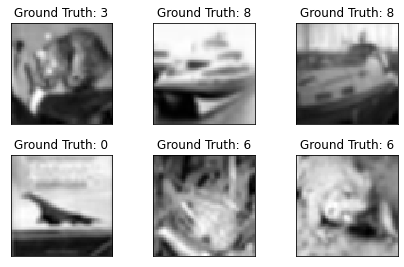

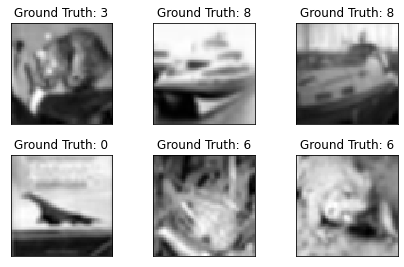

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Original ResNet-18 implementation

In [ ]:
# def conv3x3(in_planes, out_planes, stride=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=1, bias=False)


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(BasicBlock, self).__init__()
#         self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out




# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes, grayscale):
#         self.inplanes = 64
#         if grayscale:
#             in_dim = 1
#         else:
#             in_dim = 3
#         super(ResNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(7, stride=1)
#         self.fc = nn.Linear(2048 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, (2. / n)**.5)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         # because MNIST is already 1x1 here:
#         # disable avg pooling
#         #x = self.avgpool(x)
        
#         x = x.view(x.size(0), -1)
#         logits = self.fc(x)
#         probas = F.softmax(logits, dim=1)
#         return logits, probas



# def resnet18():
#     """Constructs a ResNet-18 model."""
#     model = ResNet(block=BasicBlock, 
#                    layers=[2, 2, 2, 2],
#                    num_classes=10,
#                    grayscale=True)
#     return model


In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [14]:
resnet_18 = ResNet18()
resnet_18.to(device)

print(resnet_18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

# Model Training

In [15]:
epochs = 30
lr = 0.001    

optimizer = torch.optim.SGD(resnet_18.parameters(), lr=lr, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

resnet_original, history = model_fit(
    model = resnet_18, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    loss_function = loss_function,
  )


Train Epoch 1: 
Epoch Progress: 14% Done	Current Loss: 1.74279
Epoch Progress: 28% Done	Current Loss: 1.67957
Epoch Progress: 43% Done	Current Loss: 1.60549
Epoch Progress: 57% Done	Current Loss: 1.43778
Epoch Progress: 71% Done	Current Loss: 1.52507
Epoch Progress: 85% Done	Current Loss: 1.30448
Epoch Progress: 99% Done	Current Loss: 1.30581

Average training loss: 0.01227, Training Accuracy: 19005/45000 (42.233%)
Average validation loss: 0.01050, Validation Accuracy: 2588/5000 (51.760%)

Epoch 1 of 30. Time taken: 59.59s

Train Epoch 2: 
Epoch Progress: 14% Done	Current Loss: 1.26849
Epoch Progress: 28% Done	Current Loss: 1.12891
Epoch Progress: 43% Done	Current Loss: 1.00323
Epoch Progress: 57% Done	Current Loss: 1.25880
Epoch Progress: 71% Done	Current Loss: 1.02240
Epoch Progress: 85% Done	Current Loss: 1.19697
Epoch Progress: 99% Done	Current Loss: 0.97808

Average training loss: 0.00894, Training Accuracy: 26490/45000 (58.867%)
Average validation loss: 0.00859, Validation Accur

In [16]:
images, labels, pred_labels = test(resnet_original, test_loader)


Test set Accuracy: 7546/10000 (75.460%)



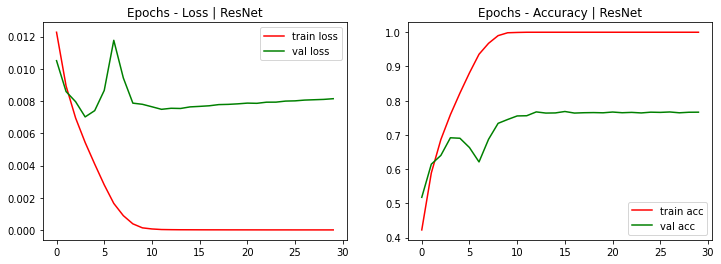

In [17]:
plot_results(epochs, history, info='ResNet', name='original_ResNet_18_plot')

array([[803,  17,  48,  20,  13,   4,  10,  13,  46,  26],
       [ 16, 881,   2,   3,   2,   6,   4,   4,  20,  62],
       [ 68,   5, 595,  70,  80,  56,  79,  31,   7,   9],
       [ 16,  13,  59, 574,  70, 146,  61,  33,  13,  15],
       [ 17,   3,  55,  51, 706,  32,  52,  70,  11,   3],
       [ 16,   5,  33, 155,  48, 648,  28,  56,   5,   6],
       [  7,   4,  38,  48,  27,  27, 831,   9,   3,   6],
       [ 24,   2,  31,  48,  52,  44,   6, 778,   7,   8],
       [ 48,  27,   7,  10,   7,   3,   7,   4, 871,  16],
       [ 25,  49,   6,  15,   4,   3,   8,   9,  22, 859]])

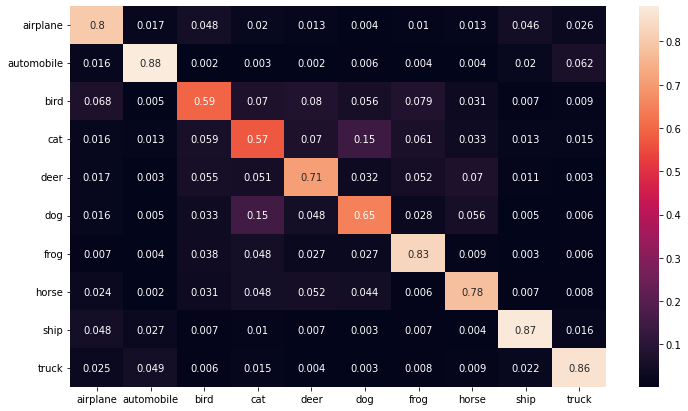

In [18]:
plot_confusion_matrix(labels, pred_labels, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

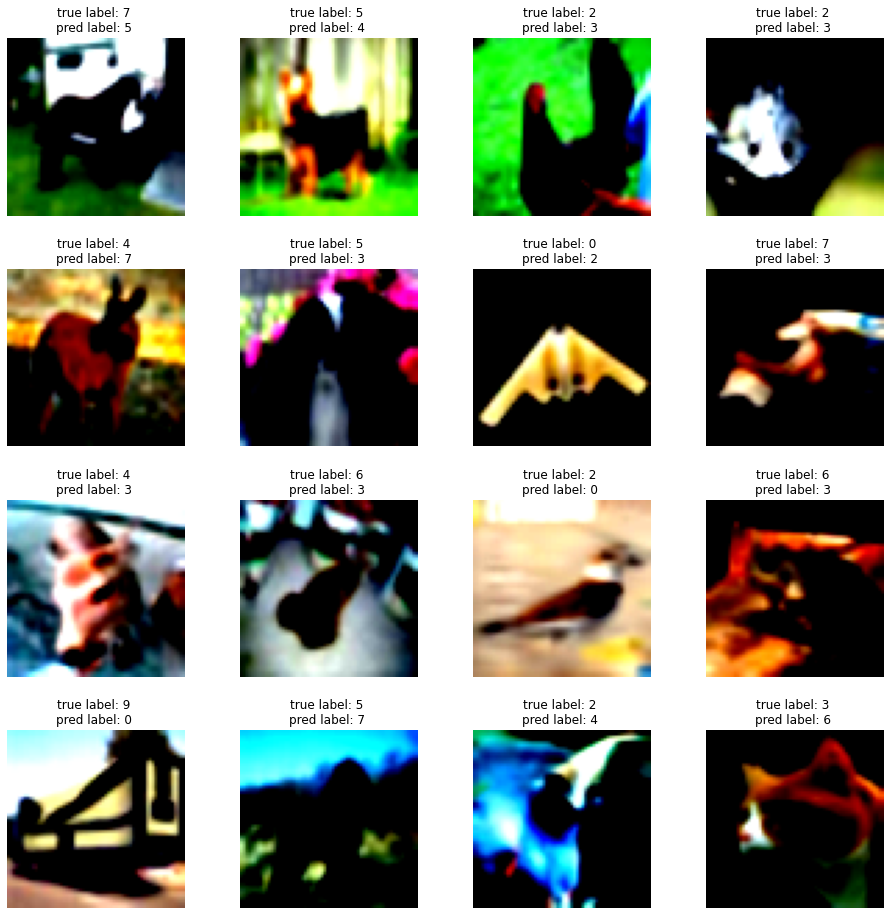

In [21]:
plot_incorrect(images, labels, pred_labels)

#**Improvement on ResNet-18**

# Data Augmentation

In [23]:
data_dir = '/content/'

def load_augmented_cifar_dataset():

  """
  Function to load the cifar dataset that returns a separate train and test set.
  Images resized to 64x64 and normalised using the datasets mean and std. This time data augmnentation
  is applied.
  """


  train_data = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.RandomAffine(degrees=20, translate=(0.2,0.2), scale=(0.7,1.3)),                                                                             
                               transforms.ToTensor(),
                               transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))

  test_data = datasets.CIFAR10(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               transforms.Resize(64),                                      
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))
  
  return train_data, test_data

In [24]:
train_data, test_data = load_augmented_cifar_dataset()

classes = get_classes(train_data)

train_set, val_set = split_train_val(train_data)

batch_size = 128

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


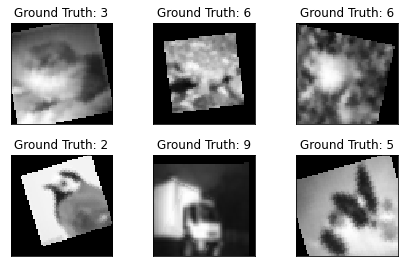

In [25]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Improved Model

In [29]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ImprovedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ImprovedResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ImprovedResNet18():
    return ImprovedResNet(BasicBlock, [2, 2, 2, 2])


In [30]:
resnet_18_improved = ImprovedResNet18()
resnet_18_improved.to(device)

print(resnet_18_improved)

ImprovedResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [31]:
epochs = 30
lr = 0.001

optimizer = torch.optim.SGD(resnet_18_improved.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()


resnet_improved, history_improved = model_fit(
    model = resnet_18_improved, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    loss_function = loss_function,
  )


Train Epoch 1: 
Epoch Progress: 14% Done	Current Loss: 1.89182
Epoch Progress: 28% Done	Current Loss: 1.77092
Epoch Progress: 43% Done	Current Loss: 1.69245
Epoch Progress: 57% Done	Current Loss: 1.63103
Epoch Progress: 71% Done	Current Loss: 1.59399
Epoch Progress: 85% Done	Current Loss: 1.80227
Epoch Progress: 99% Done	Current Loss: 1.60470

Average training loss: 0.01360, Training Accuracy: 15868/45000 (35.262%)
Average validation loss: 0.01280, Validation Accuracy: 2123/5000 (42.460%)

Epoch 1 of 30. Time taken: 84.81s

Train Epoch 2: 
Epoch Progress: 14% Done	Current Loss: 1.42108
Epoch Progress: 28% Done	Current Loss: 1.50629
Epoch Progress: 43% Done	Current Loss: 1.35481
Epoch Progress: 57% Done	Current Loss: 1.50150
Epoch Progress: 71% Done	Current Loss: 1.22565
Epoch Progress: 85% Done	Current Loss: 1.37335
Epoch Progress: 99% Done	Current Loss: 1.24798

Average training loss: 0.01101, Training Accuracy: 21958/45000 (48.796%)
Average validation loss: 0.01133, Validation Accur

In [32]:
images, labels, pred_labels = test(resnet_improved, test_loader)


Test set Accuracy: 8255/10000 (82.550%)



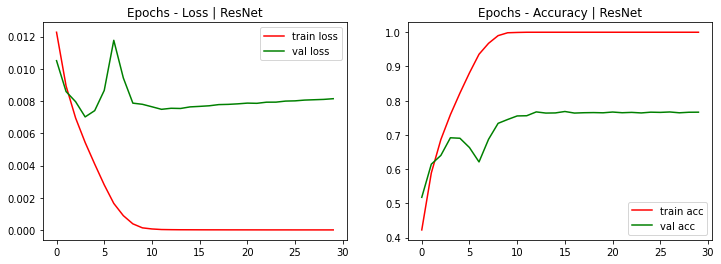

In [33]:
plot_results(epochs, history, info='ResNet', name='improved_ResNet_18_plot')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

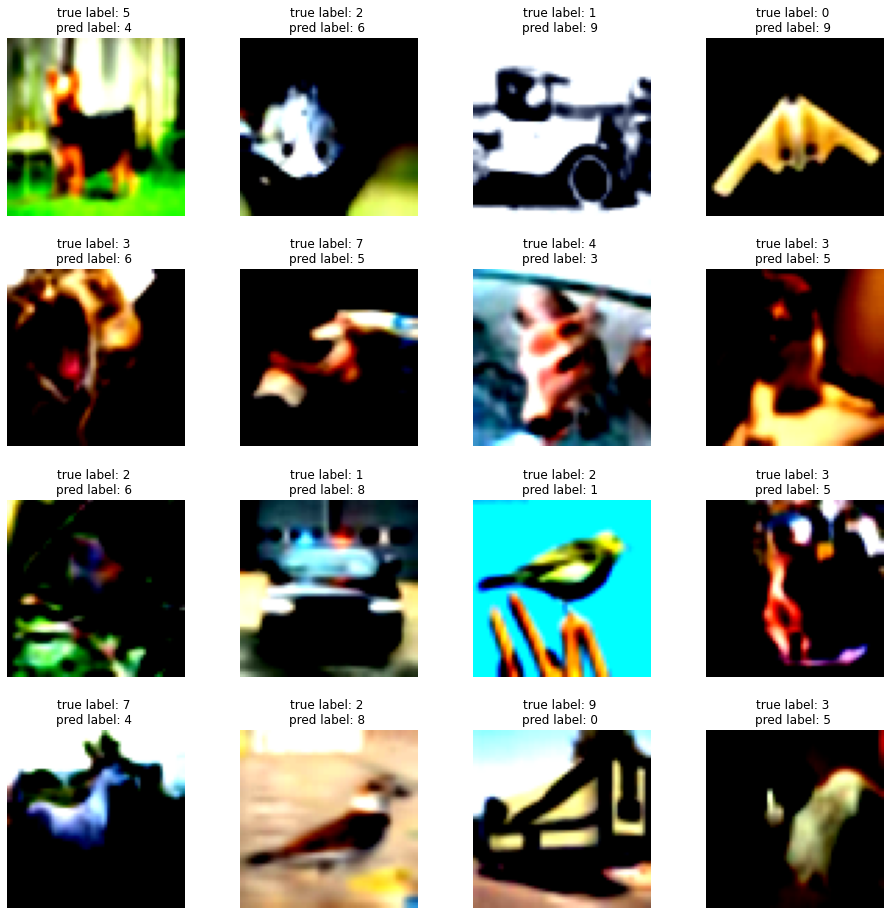

In [34]:
plot_incorrect(images, labels, pred_labels)